These produce a final .json file that can be used as an input in chemiscope to produce the final figures of the manuscript. 
The file can be already found in the downloaded folder.
However, if you want to run the notebook yourself, a new chemiscope file will be generated, along with new pcovr figures. 

In [1]:
from data import DATA_3DCD, DATA_MP
import pickle
from IPython.display import clear_output
from sklearn.model_selection import learning_curve

PRODUCTION DATA PRESENT


In [2]:
%run ./modules.ipynb

sns.set(style="white", palette="muted", color_codes=True)
my_c = colors.ListedColormap(["mediumblue", "red"])
c = ["mediumblue", "red"]
sns.set_palette(sns.color_palette(c))

n_PC = 5  # number of principal components
mixing = 0.5  # beta parameter for pcvor

3DCD data analysis

In [3]:
npzfile_3dcd = np.load(DATA_3DCD.soap, allow_pickle=True)
my_frames_3dcd = ase.io.read(DATA_3DCD.structures, index=":")
magic_3dcd = np.array(npzfile_3dcd["magic"], dtype=int).reshape(-1,1)
y_magic_3dcd = np.copy(magic_3dcd.reshape(-1, 1).ravel())

In [4]:
npzfile_mp = np.load(DATA_MP.soap, allow_pickle=True)
my_frames_mp = ase.io.read(DATA_MP.structures, index=":")
magic_mp = np.array(npzfile_mp["magic"], dtype=int).reshape(-1,1)
y_magic_mp = np.copy(magic_mp.reshape(-1, 1).ravel())

In [5]:
my_frames = np.array([*my_frames_3dcd, *my_frames_mp])
my_orig_frames = np.array([*my_frames_3dcd, *my_frames_mp])
del my_frames_mp, my_frames_3dcd

<ipython-input-5-89df66f8f642>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_frames = np.array([*my_frames_3dcd, *my_frames_mp])
<ipython-input-5-89df66f8f642>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_orig_frames = np.array([*my_frames_3dcd, *my_frames_mp])


In [6]:
y_magic = np.hstack((y_magic_3dcd, y_magic_mp))
del magic_mp, magic_3dcd, y_magic_3dcd, y_magic_mp

In [7]:
for frame in tqdm(my_frames):
    frame.numbers = np.zeros((len(frame)))
    frame.pbc = True
    frame.wrap(eps=1E-10)

  0%|          | 0/163843 [00:00<?, ?it/s]

In [8]:
hypers = dict(
    soap_type="PowerSpectrum",
    max_radial=4,
    max_angular=4,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.5,
    cutoff_smooth_width=0.5,
    global_species=[0],
    expansion_by_species_method="user defined",
    normalize=False,
)

In [9]:
if os.path.exists('train_indices_all.npy'):
    i_train, i_test = np.load('train_indices_all.npy'), np.load('test_indices_all.npy')
    y_train, y_test = y_magic[i_train], y_magic[i_test]
else:
    print('generating')
    i_train, i_test, y_train, y_test = train_test_split(
        np.arange(X.shape[0]), y_magic, train_size=0.9
    )
    np.save('train_indices_all.npy', i_train)
    np.save('test_indices_all.npy', i_test)

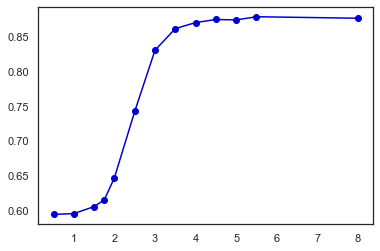

In [10]:
rads = [0.5, 1.0, 1.5, 1.75, *[round(x, 2) for x in np.arange(2.0, 6.0, 0.5)], 8.0]
errors = np.zeros(len(rads))
FN_test_all = np.zeros(len(rads), dtype=int)
FP_test_all = np.zeros(len(rads), dtype=int)
TN_test_all = np.zeros(len(rads), dtype=int)
TP_test_all = np.zeros(len(rads), dtype=int)

for i, r in enumerate(rads):
    if not os.path.exists('soaps_{}.npy'.format(r)):
        representation=SOAP(interaction_cutoff=r, **hypers)
        n_soap = representation.transform(my_frames[0]).get_features(representation).shape[1]

        fn = 'soaps_{}.npy'.format(r)
        blocks = np.array_split(np.arange(len(my_frames)), 500)
        if os.path.exists(fn):
            X_raw = np.load(fn)
        else:
            X_raw = np.zeros((len(my_frames), n_soap))
            for b1, block in enumerate(tqdm(blocks)):
                frames = my_frames[block]
                for frame in frames:
                    frame.pbc = True
                    frame.wrap(eps=1E-10)
                centers = [len(f) for f in frames]
                csi_split = [0, *np.cumsum(centers)]
                idxi = [range(csi_split[ii], csi_split[ii + 1]) for ii in range(len(block))]

                try:
                    feats = representation.transform(frames).get_features(representation)
                    for ii, idx in zip(block, idxi):
                        X_raw[ii] = feats[idx].mean(axis=0)
                except RuntimeError:
                    for ii, f in zip(block, frames):
                        try:
                            X_raw[ii] = representation.transform(f).get_features(representation).mean(axis=0)
                        except RuntimeError:
                            print("Problem with", ii)
                        
            np.save(fn, X_raw)
    X = np.load('soaps_{}.npy'.format(r))
    X_train, X_test = X[i_train], X[i_test]
    if os.path.exists("x_scaler_blanked_{}.sav".format(r)):
        x_scaler = pickle.load(open("x_scaler_blanked_{}.sav".format(r), 'rb'))
    else:
        x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
        pickle.dump(x_scaler, open("x_scaler_blanked_{}.sav".format(r), "wb"))

    X = x_scaler.transform(X)
    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    if os.path.exists('random_forest_all_blanked_{}.sav'.format(r)):
        clf = pickle.load(open('random_forest_all_blanked_{}.sav'.format(r), 'rb'))
    else:
        clf = RandomForestClassifier(verbose=2, n_estimators=100, random_state=2, n_jobs=4)
        clf.fit(X_train, y_train.ravel())
        pickle.dump(clf, open('random_forest_all_blanked_{}.sav'.format(r), 'wb'))
    errors[i] = clf.score(X_test, y_test.ravel())
    prob = clf.predict_proba(X)
    TP_test_all[i] = len(np.where(np.logical_and(y_test==1, prob[i_test][:, 1] > 0.5))[0])
    TN_test_all[i] = len(np.where(np.logical_and(y_test==0, prob[i_test][:, 0] > 0.5))[0])
    FP_test_all[i] = len(np.where(np.logical_and(y_test==0, prob[i_test][:, 1] > 0.5))[0])
    FN_test_all[i] = len(np.where(np.logical_and(y_test==1, prob[i_test][:, 0] > 0.5))[0])
    clear_output()
plt.plot(rads, errors, marker='o')

In [11]:
from sklearn.decomposition import PCA

r = 4.0
X_raw = np.load('soaps_{}.npy'.format(r))
X_train, X_test = X[i_train], X_raw[i_test]
x_scaler = pickle.load(open("x_scaler_blanked_{}.sav".format(r), 'rb'))
X = x_scaler.transform(X_raw)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
clf = pickle.load(open('random_forest_all_blanked_{}.sav'.format(r), 'rb'))

TP_test = np.where(np.logical_and(y_test==1, prob[i_test][:, 1] > 0.5))[0]
TN_test = np.where(np.logical_and(y_test==0, prob[i_test][:, 0] > 0.5))[0]
FP_test = np.where(np.logical_and(y_test==0, prob[i_test][:, 1] > 0.5))[0]
FN_test = np.where(np.logical_and(y_test==1, prob[i_test][:, 0] > 0.5))[0]

In [12]:
print("Accuracy on test set:" + str(clf.score(X_test, y_test.ravel())))

Accuracy on test set:0.8705523344522429


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


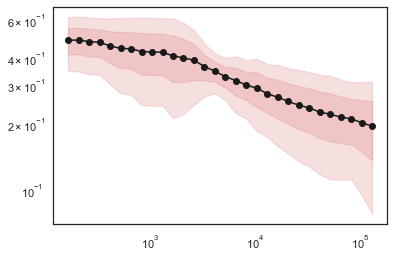

In [13]:
if not os.path.exists('lc_{}.npz'.format(r)):
    temp_rf = RandomForestClassifier(verbose=False, n_estimators=100, random_state=2, n_jobs=4)
    lc = learning_curve(temp_rf, X, y_magic, verbose=2, 
                        train_sizes=np.array(X.shape[0] * np.logspace(-3, np.log10(0.8), 30), dtype=int), 
                        cv=5)
    np.savez('lc_{}.npz'.format(r), n=lc[0], train=lc[1], test=lc[2])

lc = np.load('lc_{}.npz'.format(r))
n = lc['n']
train_errors = lc['train']
test_errors = lc['test']

error = 1.0 - test_errors
plt.loglog(n, np.mean(error, axis=1), marker='o', color='k')

for a in [1,2]:
    plt.fill_between(n, 
                     np.mean(error, axis=1) - a*np.std(error, axis=1),
                     np.mean(error, axis=1) + a*np.std(error, axis=1),
                     alpha=0.2,
                     color='r'
                    )

In [14]:
prob = clf.predict_proba(X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


<ipython-input-17-f0bda8fb1851>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


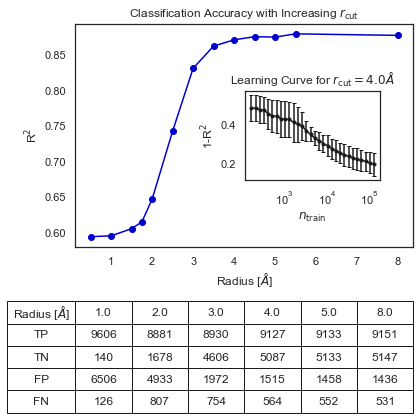

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, axes = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw=dict(height_ratios=(2,1)))

ax_rad = axes[0]
ax_tab = axes[1]
ax_lc = inset_axes(ax_rad, width='40%', height='40%', loc='center right', borderpad=3)

ax_rad.plot(rads, errors, marker='o')

sub_rads = [1, 2, 3, 4, 5, 8]
sub_i = np.array([i for i, r in enumerate(rads) if r in sub_rads])
tab = ax_tab.table([np.array(rads)[sub_i], TP_test_all[sub_i], TN_test_all[sub_i], FP_test_all[sub_i], FN_test_all[sub_i]], 
            rowLabels=[r'Radius [$\AA$]','TP', 'TN','FP','FN'], 
            cellLoc='center',
            rowLoc='center',
            bbox=(0.0,0,1,1), loc='center right')
ax_rad.set_xlabel("Radius [$\AA$]")
ax_rad.set_ylabel("R$^2$")
ax_rad.set_title("Classification Accuracy with Increasing $r_\mathrm{cut}$")
ax_tab.axis('off')

error = 1.0 - test_errors
ax_lc.errorbar(n, np.mean(error, axis=1), np.std(error, axis=1), marker='.', capsize=2, color='k')
ax_lc.set_xscale('log')

ax_lc.set_ylabel(r'1-R$^2$')
ax_lc.set_xlabel(r'$n_\mathrm{train}$')
ax_lc.set_title("Learning Curve for $r_\mathrm{cut} = 4.0\AA$")
fig.subplots_adjust(hspace=0.5)

fig.tight_layout()
plt.savefig("random_forest.pdf")